# Deep Learning: Long Short-Term Memory (LSTM)


## 1. Introduction

Five years of AstraZeneca historical stock data will be used to predict Adjusted Close prices by building a multi-layer LSTM Recurrent Neural Network model. The ability to store information over a period of time is useful when dealing with time series data. 



## 2. Install/import libraries

In [ ]:
!pip install yfinance as yfinance

In [ ]:
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import math
import datetime
import keras
import warnings
warnings.filterwarnings('ignore')

from datetime import date, timedelta
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

%matplotlib inline

## 3. Import data

Read in AstraZeneca stock data for 2014-2019 downloaded from Yahoo! Finance using yfinance API into a pandas DataFrame.

In [ ]:
azn_df = yf.download("AZN.L", start="2014-07-10", end="2019-07-11")
azn_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-07-10,4358.5,4371.000000,4326.5,4345.0,3323.517090,1692025
2014-07-11,4346.0,4375.082031,4330.0,4353.5,3330.018555,965145
2014-07-14,4375.0,4393.500000,4358.0,4369.5,3342.256836,1492796
2014-07-15,4378.0,4423.000000,4375.0,4384.5,3353.730469,1458661
2014-07-16,4380.0,4389.750000,4335.5,4371.0,3343.404297,2673194
...,...,...,...,...,...,...
2019-07-04,6606.0,6611.000000,6548.0,6578.0,6209.681152,925371
2019-07-05,6577.0,6609.000000,6509.0,6527.0,6161.537109,1156314
2019-07-08,6460.0,6468.000000,6417.0,6437.0,6076.576660,1504293


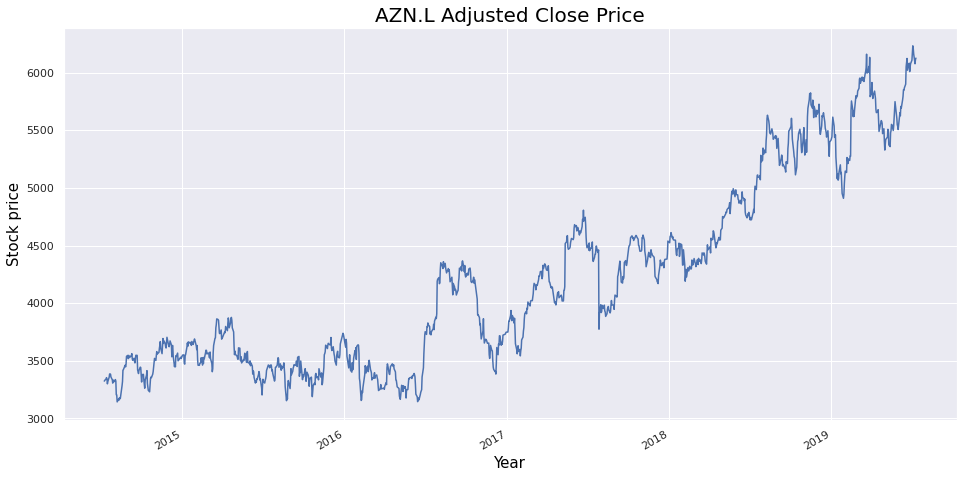

In [ ]:
# Plot Adjusted Close price

azn_df['Adj Close'].plot(grid = True)
sns.set(rc={'figure.figsize':(16, 8)})
plt.title('AZN.L Adjusted Close Price', color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock price', color = 'black', fontsize = 15);

In [ ]:
# Create DataFrame for Adjusted Close price

azn_adj = azn_df[['Adj Close']]

In [ ]:
azn_adj

,Adj Close
Date,
2014-07-10,3323.517090
2014-07-11,3330.018555
2014-07-14,3342.256836
2014-07-15,3353.730469
2014-07-16,3343.404297
...,...
2019-07-04,6209.681152
2019-07-05,6161.537109
2019-07-08,6076.576660


## 4. Create training data set

In [ ]:
# Convert DataFrame to numpy array
azn_adj_arr = azn_adj.values

# Find number of rows to train model on (80% of data set) 
training_data_len = int(0.8*len(azn_adj))

training_data_len

1008

In [ ]:
# Create train data set

train = azn_adj_arr[0:training_data_len, :]

### Feature scaling

We will normalise the training data before model fitting by converting the values of numeric columns in the data set to a common scale. Scikit-Learn’s MinMaxScaler() function scales the data to values between 0 and 1 which helps boost performance.

In [ ]:
# Normalise the data
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train)

train_scaled

array([[0.09740289],
       [0.10091837],
       [0.10753585],
       ...,
       [0.8634877 ],
       [0.89010021],
       [0.90291354]])

In [ ]:
train_scaled.shape

(1008, 1)

## Split training data into X_train, y_train

In [ ]:
# Creating a data structure with 60 time-steps and 1 output

# Split data into X_train and y_train data sets
X_train = []
y_train = []
# Creating a data structure with 60 time-steps and 1 output
for i in range(60, len(train_scaled)):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i:i+1, 0])  
    if i <= 61:     # 60 days for first pass, 61 for second
      print(X_train)
      print(y_train)
      print()

[array([0.09740289, 0.10091837, 0.10753585, 0.11373988, 0.10815631,
       0.08478811, 0.09533453, 0.1160147 , 0.13090444, 0.12883661,
       0.13028372, 0.11684215, 0.10402011, 0.08809712, 0.102573  ,
       0.09719616, 0.09471434, 0.10464057, 0.09760949, 0.03329468,
       0.03288122, 0.        , 0.01282164, 0.00806526, 0.01879121,
       0.01648695, 0.0150203 , 0.06069003, 0.0761927 , 0.09567552,
       0.14867758, 0.15140098, 0.17214122, 0.16438949, 0.17716888,
       0.2138304 , 0.21822969, 0.20293652, 0.21801992, 0.20943097,
       0.20796445, 0.21592529, 0.21822969, 0.22639976, 0.20209864,
       0.19497608, 0.20461241, 0.19057666, 0.18282532, 0.201051  ,
       0.21864869, 0.21822969, 0.14972496, 0.14218339, 0.13296554,
       0.14742069, 0.163133  , 0.16124747, 0.12730936, 0.09337112])]
[array([0.12793774])]

[array([0.09740289, 0.10091837, 0.10753585, 0.11373988, 0.10815631,
       0.08478811, 0.09533453, 0.1160147 , 0.13090444, 0.12883661,
       0.13028372, 0.11684215, 0.10

In [ ]:
# Convert X_train and y_train to numpy arrays for training LSTM model
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# Reshape the data as LSTM expects 3-D data (samples, time steps, features)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(948, 60, 1)

### Create and train model

We will create and train a model with four recurrent layers each with 50 neurons, input shape of data with number of time steps (60) and dimensionality (1), and an output layer with time step of 1, and the tanh activation function. Dropout will be used after each hidden layer as a regularisation technique to prevent overfitting. The model will be compiled using the Mean Squared Error loss function and the adam (Adaptive Moment Estimation) optimizer then fitted on the training set for 200 epochs with a batch size of 64.

In [ ]:
# Build model - LSTM with 50 neurons and 4 hidden layers  

model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1), activation='tanh'))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, activation='tanh'))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, activation='tanh'))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, activation='tanh'))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 200, batch_size = 64)

Epoch 1/200
15/15 [==============================] - 7s 124ms/step - loss: 0.1005
Epoch 2/200
15/15 [==============================] - 2s 125ms/step - loss: 0.0184
Epoch 3/200
15/15 [==============================] - 2s 124ms/step - loss: 0.0109
Epoch 4/200
15/15 [==============================] - 2s 123ms/step - loss: 0.0122
Epoch 5/200
15/15 [==============================] - 2s 127ms/step - loss: 0.0111
Epoch 6/200
15/15 [==============================] - 2s 126ms/step - loss: 0.0105
Epoch 7/200
15/15 [==============================] - 2s 127ms/step - loss: 0.0100
Epoch 8/200
15/15 [==============================] - 2s 126ms/step - loss: 0.0106
Epoch 9/200
15/15 [==============================] - 2s 127ms/step - loss: 0.0093
Epoch 10/200
15/15 [==============================] - 2s 128ms/step - loss: 0.0092
Epoch 11/200
15/15 [==============================] - 2s 127ms/step - loss: 0.0079
Epoch 12/200
15/15 [==============================] - 2s 126ms/step - loss: 0.0082
Epoch 13/200


### Create test set

In [ ]:
test = azn_adj_arr[training_data_len: , :]

In [ ]:
test.shape

(253, 1)

In [ ]:
# Predicting 253 values, using past 60 from the train data
inputs = azn_adj_arr[len(azn_adj_arr) - len(test) - 60:]
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [ ]:
# Create data sets X_test and y_test
X_test = []
y_test = azn_adj_arr[training_data_len:, :]
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])

In [ ]:
# Convert data to numpy array
X_test = np.array(X_test)

In [ ]:
# Reshape data to be 3-D
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
print(X_test.shape)

(253, 60, 1)


### Make Predictions using the test set

In [ ]:
# We want predictions to contain same values as y_test data set
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [ ]:
predictions.shape

(253, 1)

### Calculate the RMSE using the actual values

RMSE is the standard deviation of the residuals and is a good measure of how accurately the model predicts the reponse. Lower values of RMSE indicate a better fit.

In [ ]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)  
rmse

78.81636572072628

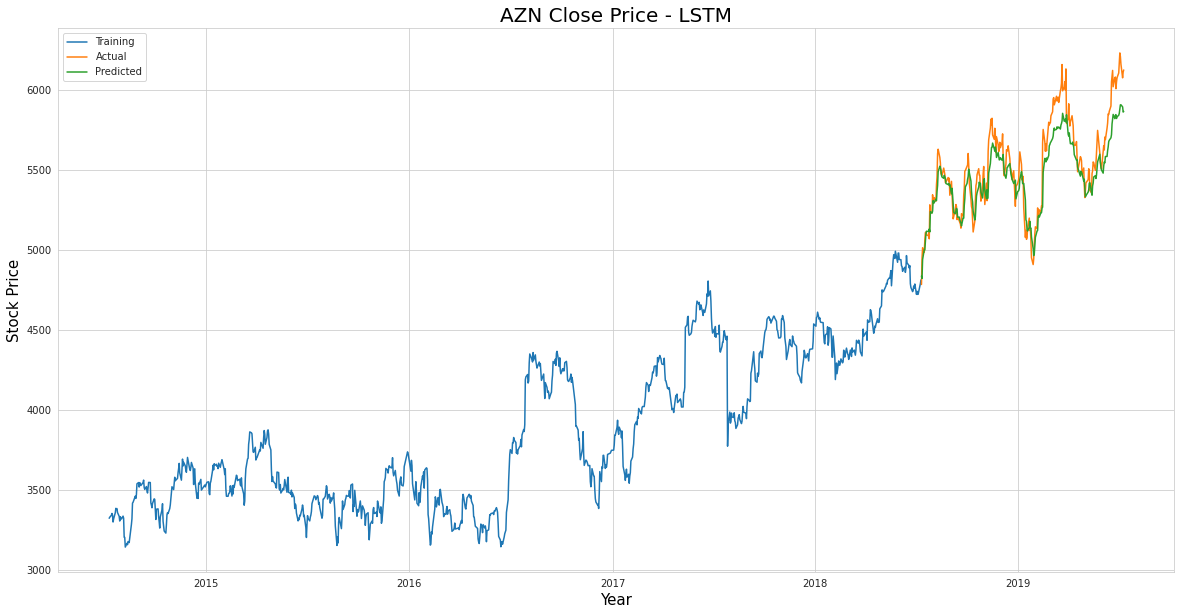

In [ ]:
# Plot predicted vs actual values  
train = azn_adj[:training_data_len]
test = azn_adj[training_data_len:]
test['Predictions'] = predictions

plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("AZN Close Price - LSTM", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price', color = 'black', fontsize = 15)
plt.legend();

### DataFrame of actual vs predicted prices plotted above

In [ ]:
# Show the actual and predicted prices  

test

,Adj Close,Predictions
Date,,
2018-07-11,4784.962402,4836.467285
2018-07-12,4952.665039,4822.513672
2018-07-13,5014.641602,4940.193359
2018-07-16,4985.669922,5002.452637
2018-07-17,5059.300781,5000.371094
...,...,...
2019-07-04,6209.681152,5907.742188
2019-07-05,6161.537109,5908.046875
2019-07-08,6076.576660,5894.851562


### Predict Adjusted Close price for 11 July 2019

In [ ]:
# Predict Adjusted Close price for AZN stock for 11 Jul 2019   
# get the quote
azn_quote = yf.download("AZN.L", start="2015-07-10", end="2019-07-12")
# Create new df
new_df = azn_quote.filter(['Adj Close'])
# Get last 60 days closing price and convert df to array])
last_60_days = new_df[-60:].values
# Scale data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
# Create empty list
X_test = []
# Append last 60 days 
X_test.append(last_60_days_scaled)
# Convert the X_test data set to numpy array
X_test = np.array(X_test)
# Reshape data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get predicted price
pred_price = model.predict(X_test)
# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[*********************100%***********************]  1 of 1 completed
[[5829.375]]


### Actual Adjusted Close price for 11 July 2019

In [ ]:
# Actual price
azn_quote2 = yf.download("AZN.L", start="2019-07-11", end="2019-07-12")
print(azn_quote2['Adj Close'])

[*********************100%***********************]  1 of 1 completed
Date
2019-07-11    6024.65625
Name: Adj Close, dtype: float64


The predicted Adjusted Close price for 11 July 2019 was 5829.4, lower than the actual price of 6024.7. Accuracy could be improved by trying different numbers of layers, epochs and batch sizes. 